# Long Short-TermMemory Recurrent Neural Network

长短期记忆递归神经网络(LSTM)在语音和手写识别等众多任务中的表现优于最先进的深度神经网络。它们是专门为顺序数据设计的，这些数据在许多时间步骤上表现出模式。在时间序列分析中，这些模式被称为周期性（cyclical）。

## Cyclical Patterns in Time Series Data

时间序列数据往往具有周期性规律，即观测值在很长一段时间内上升和下降。例如，图9.1显示了美国新出售的一户式住房的月度销售情况。时间序列显示出一种循环模式。时间上的高点和低点与商业周期有关。与经济扩张相关的强劲需求推高了对房屋的需求，从而也推高了销售量。而需求疲软则与经济放缓有关，从而导致销售量下降。

In [1]:
%%html
<img src='9_1.png'> 

在自然界中也观察到周期性成分。图9.2显示了比利时布鲁塞尔皇家天文台自18世纪以来收集的每月太阳黑子数量。这些数据以11年为一个周期，在9至14年之间变化。电信公司对太阳黑子活动很感兴趣，因为它们会影响电离层的无线电波传播。科学家和电信公司希望能提前预警其水平。

In [2]:
%%html
<img src='9_2.png'> 

在本章中，我们开发了一个LSTM，利用图9.2所示的数据提前一个月预测太阳黑子的活动水平。目标是建立一个准确到±50容差/舒适区间的预测模型。

In [1]:
import numpy as np 
import pandas as pd 
data = pd.read_csv("SN_m_tot_V2.0.csv", sep=";")
data.to_csv("Monthly Sunspots.csv")
data_csv = pd.read_csv("Monthly Sunspots.csv", header=None)

## Efficiently Explore and Quickly Understand Data
数据从1749年1月开始，到今天结束。(截止到2020年11月)下载地址：https://goo.gl/uWbihf

In [2]:
yt = data_csv.iloc[0:3263, 4]
yt.head()

0     96.7
1    104.3
2    116.7
3     92.8
4    141.7
Name: 4, dtype: float64

In [3]:
yt.tail()

3258     6.3
3259     7.6
3260     0.7
3261    14.4
3262    34.0
Name: 4, dtype: float64

## Adding Time Lags to Data
对于我们的模型，我们使用5个时间滞后的数据。时滞数据的快速方法是使用shift函数。

In [4]:
yt_1 = yt.shift(1)
yt_2 = yt.shift(2)
yt_3 = yt.shift(3)
yt_4 = yt.shift(4)
yt_5 = yt.shift(5)

In [5]:
data = pd.concat ([ yt, yt_1, yt_2, yt_3, yt_4,yt_5], axis=1)
data.columns = ['yt', 'yt_1', 'yt_2', 'yt_3', 'yt_4', 'yt_5']

变量yt包含当前月份的太阳黑子数量。
- yt_1包含前1个月的太阳黑子数量。
- yt_5是五个月前的太阳黑子数量。

In [6]:
data.tail(6)

,yt,yt_1,yt_2,yt_3,yt_4,yt_5
3257,5.8,0.2,5.2,1.5,0.2,6.2
3258,6.3,5.8,0.2,5.2,1.5,0.2
3259,7.6,6.3,5.8,0.2,5.2,1.5
3260,0.7,7.6,6.3,5.8,0.2,5.2
3261,14.4,0.7,7.6,6.3,5.8,0.2
3262,34.0,14.4,0.7,7.6,6.3,5.8


yt_1有一个缺失值（如预期），yt_5有五个缺失值（同样如预期）。用dropna()方法删除这些缺失值，并将属性存储在x中，将当前的太阳黑子数量（我们的目标变量）存储在y中。

In [7]:
data = data.dropna()
y = data['yt']
cols = ['yt_1', 'yt_2', 'yt_3', 'yt_4', 'yt_5']
x = data[ cols ]

In [8]:
data.head()

,yt,yt_1,yt_2,yt_3,yt_4,yt_5
5,139.2,141.7,92.8,116.7,104.3,96.7
6,158.0,139.2,141.7,92.8,116.7,104.3
7,110.5,158.0,139.2,141.7,92.8,116.7
8,126.5,110.5,158.0,139.2,141.7,92.8
9,125.8,126.5,110.5,158.0,139.2,141.7


## The LSTM Memory Block in a Nutshell
- 1. 它包含一个记忆单元和三个乘法门单元--输入门、输出门和遗忘门。
- 2. 输入到存储器块的输入是由输入门的激活而乘以的。
- 3. 输出被输出门乘以，之前的单元值被遗忘门乘以。
- 4. 闸门控制信息流入和流出存储器单元。

## Straightforward Data Transformation for the Train and Test Sets

In [9]:
from sklearn import preprocessing
scaler_x = preprocessing.MinMaxScaler(feature_range = ( -1 , 1))
x = np.array(x).reshape(( len(x), 5 ))
x = scaler_x.fit_transform(x)
scaler_y = preprocessing.MinMaxScaler(feature_range = ( -1 , 1))
y = np.array(y).reshape(( len(y), 1))
y = scaler_y.fit_transform(y)

## The Train Set
训练集：从开始到2005.12，测试集，从2006.1到2019.12

In [10]:
train_end = 3084
x_train = x[0:train_end, ]
x_test = x[train_end+1:3252, ]
y_train = y[0:train_end]
y_test = y[train_end+1:3252]
x_train = x_train.reshape(x_train.shape + (1 ,))
x_test = x_test.reshape(x_test.shape + (1 ,))

门控机制是允许LSTMs明确地模拟长期依赖关系的原因。输入、遗忘和输出门学习在内存中存储什么信息，存储多长时间，以及何时将其读出。通过从数据中获取这些信息，网络学习其内存应该如何行为。

- Input 输入门学习保护细胞不受不相关输入的影响。它控制输入激活流入记忆单元的流量。只要它的"写"门开启，信息就会进入单元。
- Forget 只要单元格的遗忘门 "关闭"，信息就会留在单元格中。必要时，遗忘门允许单元格自我复位为零。
- Output 输出门控制细胞激活的输出流向网络的其他部分。通过打开细胞的输出门，可以从细胞中读取信息。LSTM学会关闭正在产生不相关输出的存储器块。

## Understand the Constant Error Carousel
记忆单元可以长期保持其状态。它通常被称为 "恒定错误转盘"。这是因为它的核心是一个反复自连接的线性单元，它无限期地循环激活和错误信号。这使得它可以为长时间提供短期记忆存储。
## Specifying a LSTM Model the Easy Way
内存块的数量由LSTM函数中的output_dim参数控制。为了便于说明，指定了四个内存块。内单元的激活函数被设置为硬sigmoid。

In [11]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
seed = 2020
np.random.seed(seed)
fit1 = Sequential ()
fit1.add(LSTM( units = 4, activation = 'tanh', recurrent_activation = 'hard_sigmoid', input_shape =(5, 1)))
fit1.add(Dense( units = 1, activation = 'linear'))

与我们目前看到的所有Keras模型一样，首先调用Sequential()模型，然后是模型规范。通过Dense函数调用输出层，从而得到一个具有线性激活函数的全连接层。

## An alternative to Stochastic Gradient Descent
设置学习率涉及到一个反复调整的过程，在这个过程中，我们手动设置一个可能的最高值。选择过高的值会导致系统出现分歧，而选择这个速率过低会导致学习速度缓慢。对于很多问题来说，确定一个好的学习率更像是一门艺术，而不是科学。有一些证据表明，在随机梯度下降过程中自动调整学习率可以带来性能的提升。rmsprop算法对每个更新向量组件使用不同的学习率。它使用每个参数的梯度幅度的指数移动平均数除以该平均数的根来归一化梯度。要使用rmsprop算法，请在编译函数中设置optimizer="rmsprop"。

In [14]:
fit1.compile( loss = "mean_squared_error", optimizer = "rmsprop" )

In [16]:
fit1.fit(x_train, y_train, batch_size=1, epochs=10, shuffle=False)

Epoch 1/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0228
Epoch 2/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0188
Epoch 3/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0182
Epoch 4/10
3084/3084 [==============================] - 10s 3ms/step - loss: 0.0179
Epoch 5/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0177
Epoch 6/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0176
Epoch 7/10
3084/3084 [==============================] - 10s 3ms/step - loss: 0.0175
Epoch 8/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0175
Epoch 9/10
3084/3084 [==============================] - 10s 3ms/step - loss: 0.0174
Epoch 10/10
3084/3084 [==============================] - 10s 3ms/step - loss: 0.0174


In [17]:
fit1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


## Train and Test MSE

In [18]:
score_train = fit1.evaluate( x_train, y_train, batch_size=1)
score_test = fit1.evaluate ( x_test, y_test,batch_size=1)

167/167 [==============================] - 0s 1ms/step - loss: 0.0087


In [19]:
round(score_train,4)

0.0228

In [20]:
round(score_test,4)

0.0087

In [21]:
pred1 = fit1.predict(x_test)
pred1 = scaler_y.inverse_transform(np.array(pred1).reshape(( len(pred1), 1)))

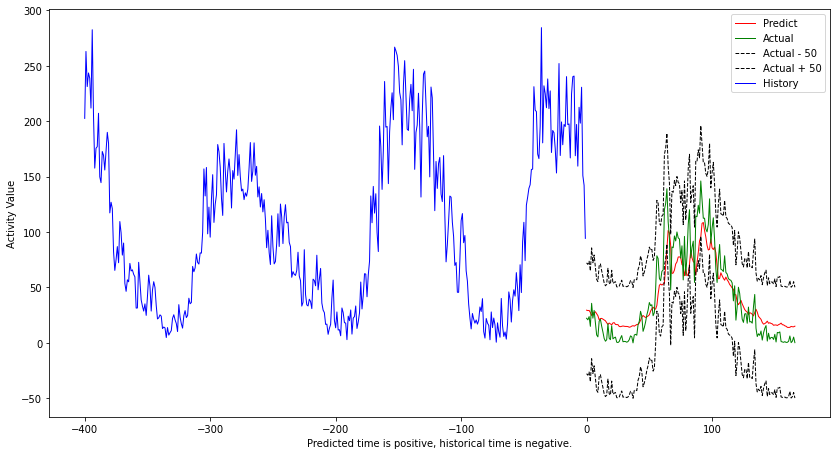

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14.0, 7.5)
real = np.array(data['yt'][0:3084]).reshape(-1)
test_reals = data['yt'][3085:3252].tolist()
history_time_length = 400
ahead = 167
plt.plot(range(0, ahead), pred1, '-r', label=u"Predict", linewidth=1)
plt.plot(range(0, ahead), test_reals[0:ahead], color='green', label=u"Actual", linewidth=1)
plt.plot(range(0, ahead), np.array(test_reals[0:ahead]) - 50, '--k',label=u"Actual - 50", linewidth=1)
plt.plot(range(0, ahead), np.array(test_reals[0:ahead]) + 50, '--k',label=u"Actual + 50", linewidth=1)
plt.plot(range(-history_time_length, 0),
                 real[len(real) - ahead - history_time_length - 1: len(real) - ahead - 1],
                 '-b', label=u"History", linewidth=1)
plt.xlabel(u"Predicted time is positive, historical time is negative.")
plt.ylabel(u"Activity Value")
plt.legend()
fig = plt.gcf()
plt.show()

## Shuffling Examples to Improve Generalization
你可能会如何改进这个模型？你可以调整一些参数，比如增加额外的内存块。一个偶尔有效的方法是设置shuffle=True。这意味着训练实例将在每个时代随机洗牌。
回顾一下，我们已经设置了数据，使每个例子由集合$y_t$和$x_t$=$[ y_{t-1}，y_{t-2}，y_{t-3}，y_{t-4}，y_{t-5} ]$组成。所以，例子1包含E1 = $[ y_1，x_1 ]$ ，例子2包含E2 = $[ y_2，x_2 ]$。一般来说，我们有一系列的例子 E1，E2，E3，...En，其中n是训练样本的长度。

只是为了说明问题，假设我们只有五个例子。
在shuffle=False的情况下，模型会按照顺序使用它们 E1, E2, E3, E4, E5。当shuffle=True时，我们可能最终会得到以下结果。以E3、E1、E5、E4、E2的顺序进行训练。只要您为您的数据选择了一个合适的滞后顺序，这种方法可以提高概括能力。

In [28]:
fit1.fit(x_train, y_train, batch_size=1, epochs=10, shuffle=True)

Epoch 1/10
3084/3084 [==============================] - 10s 3ms/step - loss: 0.0188
Epoch 2/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0186
Epoch 3/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0185
Epoch 4/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0185
Epoch 5/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0183
Epoch 6/10
3084/3084 [==============================] - 10s 3ms/step - loss: 0.0183
Epoch 7/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0182
Epoch 8/10
3084/3084 [==============================] - 10s 3ms/step - loss: 0.0183
Epoch 9/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0183
Epoch 10/10
3084/3084 [==============================] - 9s 3ms/step - loss: 0.0181


In [29]:
score_train_use_shuffle = fit1.evaluate( x_train, y_train, batch_size=1)
score_test_use_shuffle = fit1.evaluate ( x_test, y_test,batch_size=1)

167/167 [==============================] - 0s 2ms/step - loss: 0.0060


In [30]:
round(score_train_use_shuffle,4)

0.0181

In [31]:
round(score_test_use_shuffle,4)

0.006

In [32]:
pred2 = fit1.predict(x_test)
pred2 = scaler_y.inverse_transform(np.array(pred2).reshape((len(pred2), 1)))

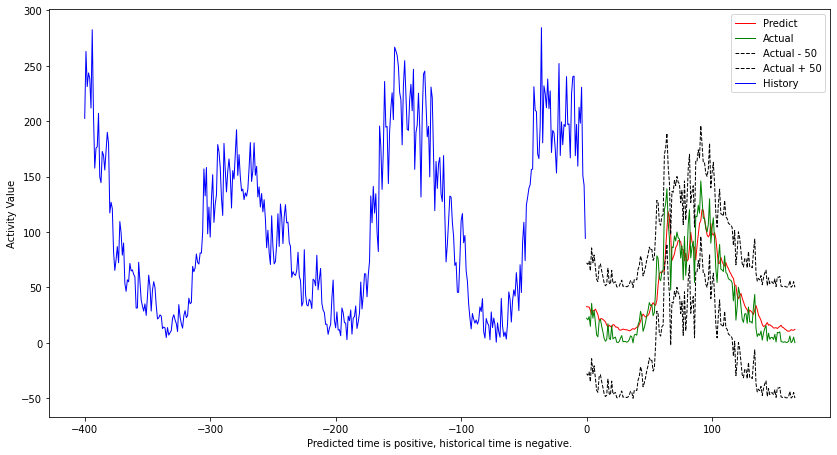

In [33]:
plt.rcParams['figure.figsize'] = (14.0, 7.5)
real = np.array(data['yt'][0:3084]).reshape(-1)
test_reals = data['yt'][3085:3252].tolist()
history_time_length = 400
ahead = 167
plt.plot(range(0, ahead), pred2, '-r', label=u"Predict", linewidth=1)
plt.plot(range(0, ahead), test_reals[0:ahead], color='green', label=u"Actual", linewidth=1)
plt.plot(range(0, ahead), np.array(test_reals[0:ahead]) - 50, '--k',label=u"Actual - 50", linewidth=1)
plt.plot(range(0, ahead), np.array(test_reals[0:ahead]) + 50, '--k',label=u"Actual + 50", linewidth=1)
plt.plot(range(-history_time_length, 0),
                 real[len(real) - ahead - history_time_length - 1: len(real) - ahead - 1],
                 '-b', label=u"History", linewidth=1)
plt.xlabel(u"Predicted time is positive, historical time is negative.")
plt.ylabel(u"Activity Value")
plt.legend()
fig = plt.gcf()
plt.show()

## A Note on Vanishing Gradients
LSTM被广泛使用，因为该架构克服了困扰递归神经网络的消失梯度问题。反向传播神经网络中的错误是指 用来驱动权重变化。通过传统的学习算法，如通过时间的反向传播或实时的 循环学习，反向传播的错误信号倾向于 缩小或以指数级速度增长。这导致用于调整网络权重的误差信号变得越来越多 难以通过网络传播。

事实证明，反传播误差随时间的演化取决于权重的大小，呈指数级。这是因为梯度本质上等于递归权重矩阵提高到一个高功率。从本质上讲 隐藏状态在每次迭代时都会被传递过来，所以在反向传播时，同一个权重矩阵会被自己乘以多次。当提高到高次幂时（即迭代过后的 时间）会导致梯度缩小（或增长），其速度为是时间步数的指数。如果梯度缩小，称为 "梯度消失"，如果梯度增长，称为 "梯度爆炸"。实际意义是通过简单地学习数据中的长期依赖性，就可以了解到 RNN可能需要大量的时间，或者可能不会发生。

LSTM避免了消失梯度问题。这就是 因为内存块中有一个单元格，存储了之前的 值，并将其保留下来，除非 "忘记门 "告诉细胞 忘记这些值。只有单元格会跟踪模型 误差，因为它在时间上流回。在每个时间步骤中，单元格状态 可以改变或保持不变。小区的局部错误 在没有新的输入或错误信号的情况下，保持不变。该单元 状态也可以反馈到当前的隐藏状态。的计算。这样一来，发生的隐藏状态的值 在一个序列的早期，可能会影响以后的观察。

## Follow these Steps to Build a Stateful LSTM
LSTM模型具有有状态的功能。这简单地意味着，每批样品的状态都会被记住，并作为下一批样品的初始状态重新使用。这是一个有用的特性，因为它允许模型在序列批次之间携带状态，这对于时间序列数据的实验是有用的。

In [38]:
fit2 = Sequential()
# 设置stateful 为 True
fit2.add(LSTM(units=4,
               stateful=True,
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               batch_input_shape=(1, 5, 1)
                       ))
fit2.add(Dense(units=1, activation='linear'))
# 使用 rmsprop 自动调整学习速率
fit2.compile(loss="mean_squared_error", optimizer="rmsprop")
# shuffle
end_point = len(x_train)
start_point = end_point - 500
for i in range(len(x_train[start_point:end_point])):
    print("Fitting example %s: " % (i+1))
    # verbose = 0，在控制台没有任何输出
    # verbose = 1 ：显示进度条
    # verbose =2：为每个epoch输出一行记录
fit2.fit(x_train[start_point: end_point],
                      y_train[start_point: end_point],
                      batch_size=1, epochs=1, verbose=2, shuffle=True)
fit2.reset_states()
score_train2 = fit2.evaluate(x_train[start_point: end_point],
                                     y_train[start_point: end_point],
                                     batch_size=1)
score_test2=fit2.evaluate(x_test, y_test, batch_size=1)
print("训练误差是:", round(score_train2, 4))
print("测试误差是:", round(score_test2, 4))

Fitting example 1: 
Fitting example 2: 
Fitting example 3: 
Fitting example 4: 
Fitting example 5: 
Fitting example 6: 
Fitting example 7: 
Fitting example 8: 
Fitting example 9: 
Fitting example 10: 
Fitting example 11: 
Fitting example 12: 
Fitting example 13: 
Fitting example 14: 
Fitting example 15: 
Fitting example 16: 
Fitting example 17: 
Fitting example 18: 
Fitting example 19: 
Fitting example 20: 
Fitting example 21: 
Fitting example 22: 
Fitting example 23: 
Fitting example 24: 
Fitting example 25: 
Fitting example 26: 
Fitting example 27: 
Fitting example 28: 
Fitting example 29: 
Fitting example 30: 
Fitting example 31: 
Fitting example 32: 
Fitting example 33: 
Fitting example 34: 
Fitting example 35: 
Fitting example 36: 
Fitting example 37: 
Fitting example 38: 
Fitting example 39: 
Fitting example 40: 
Fitting example 41: 
Fitting example 42: 
Fitting example 43: 
Fitting example 44: 
Fitting example 45: 
Fitting example 46: 
Fitting example 47: 
Fitting example 48: 
F

In [40]:
pred3 = fit2.predict(x_test, batch_size=1)
pred3 = scaler_y.inverse_transform(np.array(pred3).reshape((len(pred3), 1)))

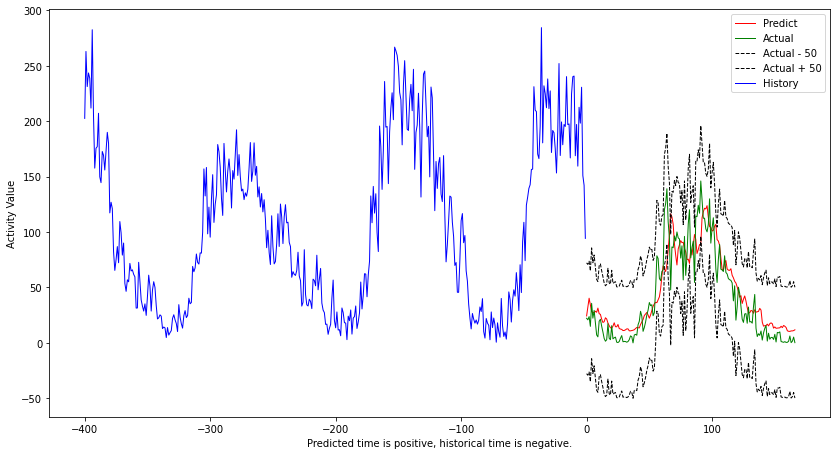

In [41]:
plt.rcParams['figure.figsize'] = (14.0, 7.5)
real = np.array(data['yt'][0:3084]).reshape(-1)
test_reals = data['yt'][3085:3252].tolist()
history_time_length = 400
ahead = 167
plt.plot(range(0, ahead), pred3, '-r', label=u"Predict", linewidth=1)
plt.plot(range(0, ahead), test_reals[0:ahead], color='green', label=u"Actual", linewidth=1)
plt.plot(range(0, ahead), np.array(test_reals[0:ahead]) - 50, '--k',label=u"Actual - 50", linewidth=1)
plt.plot(range(0, ahead), np.array(test_reals[0:ahead]) + 50, '--k',label=u"Actual + 50", linewidth=1)
plt.plot(range(-history_time_length, 0),
                 real[len(real) - ahead - history_time_length - 1: len(real) - ahead - 1],
                 '-b', label=u"History", linewidth=1)
plt.xlabel(u"Predicted time is positive, historical time is negative.")
plt.ylabel(u"Activity Value")
plt.legend()
fig = plt.gcf()
plt.show()